Name: PAK Ka Yee, Rahil MOHAN

SID: 55692027, 55414617

Kaggle Team Name: G25

# CS4487 - Course Project: DeepFake Identification
---
In this project, we aim to simplify the process of detecting DeepFake images of people from a sample of random images. To this extent, we created a Basic Convolutional Neural Network to create a baseline and replicated the methodology across 3 industry standard models

These models are -
  1. ResNet50 
  2. EficientNetB3
  3. MobileNet V2

Link to models: https://drive.google.com/drive/folders/1St67Mt8NP8eENcloyZJIaQcUC3__fL5O?usp=sharing

## Methodology

The major sections are - 
1. Import libraries/packages
2. Data Engineering 
   
   -Extraction-(Working dataset & Testing dataset) 
   
   -Splitting the data

3. Resizing the imgaes

4. Resizing image, testing dataset and ploting the confusion matrix on differnt other networks: **ResNet50, Vgg19 and EfficentNet**

5. References

## 1. Importing the Requisite libraries

---

Import necessary libraries/packages

In [1]:
import numpy as np
import pickle
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import random

import tensorflow as tf
from tensorflow.python import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import  keras_tuner as kt
from pathlib import Path

import PIL
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

import seaborn as sns

In [2]:
from IPython import display

In [3]:
downscaling = (150,150,3)

## 2. Helper Functions
---

### 2.1 Plotting images

The `plot_image_grid` function shows a grid(or row) of the example images. Here we chose 7 images within 100 images with a jump of 15. For example, if the first image is labelled 0, the next image showing would be 1010, etc. Also, in the function, `cmap='gray'` means displaying images' colour map into grayscale (black & white).

In [4]:
def plot_image_grid(images, ncols=None, cmap='gray'):
    
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
                img.text(0.5, 0.05, subtext, ha='center')
            ax.imshow(img, cmap=cmap)  
            

### 2.2 Generating the requisite datasets

The `generate_dataset` function is used to generate the dataset by using a `path` and `num_subset` value. The message `Processing (e.g. 500) images` will be printed out to show the progress. 

The value of `path` is the folder where the images are stored. `num_subset` defines the number of images to be included in the Working Set, and `truth_value` informs the function. If the images belong to the real or fake class (0 means deepfake/face2face , 1 means real). 

In [5]:
def generate_dataset(path, num_subset,truth_value):
    complete_set = []

    for dirname, _, filenames in os.walk(path):

        for filename in filenames:
            if filename.endswith('.png'):

                full_path = os.path.join(dirname, filename)
                complete_set.append(np.array(Image.open(full_path).convert('RGB')))

                if len(complete_set) % 500 == 0:
                    print(f'Processing {len(complete_set)} images')
                    
    subset_array = complete_set[:num_subset]
    truth_array = [truth_value] * len(subset_array)
    testing_array = complete_set[num_subset:]
    print(len(complete_set),len(subset_array), len(truth_array), len(testing_array))
    return subset_array, truth_array, testing_array

### 2.3 Image Conversion function

We resize each image to (150 * 150) and flatten it to an array.

The original size (299*299) corresponds to a large feature matrix which takes an appropriately large time to convert and train. We also ran into memory issues as the resultant matrix was over 20 GB.

Thus, we sought a method to resize each image to a manageable dimension using a Lanczos filter.

Ref: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#PIL.Image.LANCZOS

In [6]:
def convert_resize(dataset,image_size=(downscaling[0],downscaling[1])):
    
    count = 0
    modified_dataset = []

    for i in dataset:
        image = Image.fromarray(i)

        temp = np.array(image.resize(image_size, resample=PIL.Image.LANCZOS)).flatten() /255.0
        modified_dataset.append(temp)
        count+=1
        if count%500 == 0:
            print("Completed processing {} images".format(count))
    print("Completed processing {} images".format(count))
    return modified_dataset

### 2.6 Confusion Matrix

`plot_confusion_matrix`: the function computed a confusion matrix to evaluate the accuracy of a classification and visualised the predictions (0 or 1) with a grid heatmap.

In [7]:
def plot_confusion_matrix(truth_values, predicted_values):    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(truth_values, predicted_values)

    # plot the confusion matrix
    hm = sns.heatmap(confusion_mtx, annot=True, fmt="d")
    print('Accuracy = {}'.format(accuracy_score(truth_values,predicted_values)))

## 3. Data Engineering

---

### 3.1 Extracting the Dataset

**Characteristics of the Dataset**:
The dataset was provided via Kaggle and consisted of the requisite images being separated into 3 folders and 2 classes.

**real**: A collection of images of people's faces in slightly different expressions. The people in question belong to other races, ethnicities and are wearing a wide assortment of clothes. This makes it representative of human demographics in the real world.

**fake_deepfake**: This folder consists of images of people who have undergone modifications via DeepFake technology. A large proportion of the base images pre modifications have been derived from the real folder.

**fake_face2face**: The images in this folder have also been derived from those in the real folder but modified using face2face. This software enables real-time face control, reenactment and emotion manipulations.

Defining the destination paths where the images are stored.

In [7]:
path_real_images = 'data/real/'
path_deepfake_images = 'data/fake_deepfake/'
path_f2f_images = 'data/fake_face2face/'

In the following cell, We get the file path of the real images with `path_real_images` and split 3750 (out of 4000 images) real images into the training set and the rest 250 real images into the Testing set. 

The proportion is maintained for the DeepFake as well as the Face2Face images.

In [8]:
X_real_training, Y_real, X_real_testing = generate_dataset(path_real_images, 3750, 1)

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4000 3750 3750 250


In [9]:
X_df_training, Y_df, X_df_testing = generate_dataset(path_deepfake_images, 3750, 0)

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4000 3750 3750 250


In [10]:
X_f2f_training, Y_f2f, X_f2f_testing = generate_dataset(path_f2f_images, 3750, 0)

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4000 3750 3750 250


With the help of the `plot_image_grid()` function, we print 7 random images from each of the 3 initial training sets.



**Real Images**

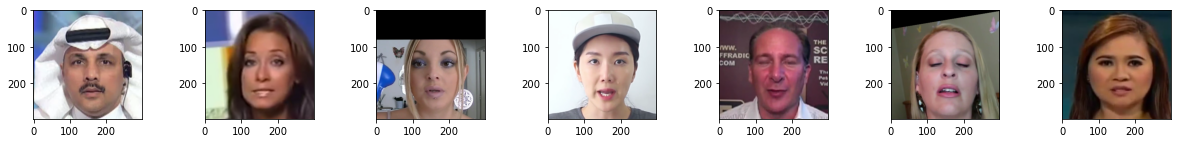

In [11]:
plot_image_grid(X_real_training[0:100:15])

**DeepFake Images**

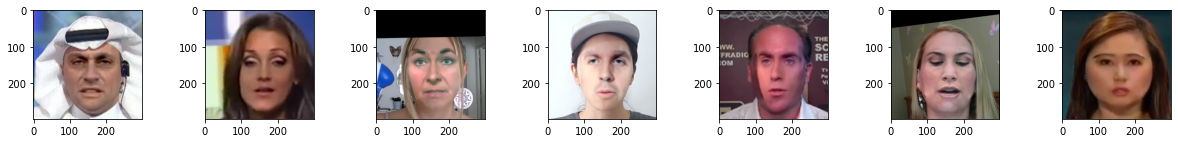

In [12]:
plot_image_grid(X_df_training[0:100:15])

**Face2Face Images**

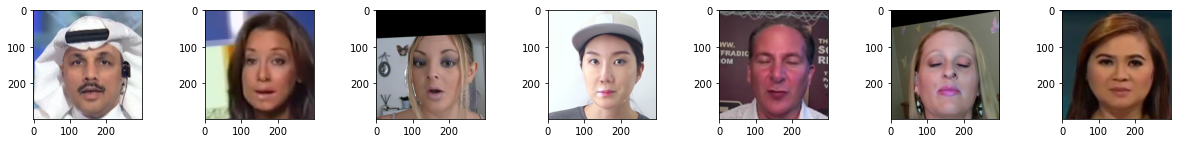

In [13]:
plot_image_grid(X_f2f_training[0:100:15])

The below three-step is to convert ELA, take an array of images and converting into ELA form and update back to the original value.


In [14]:
X_real_training = convert_resize(X_real_training)

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images


In [15]:
X_df_training = convert_resize(X_df_training)

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images


In [16]:
X_f2f_training = convert_resize(X_f2f_training)

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images


Generating Overarching Training Set

In [17]:
X_real_training = X_real_training + X_df_training + X_f2f_training
X = X_real_training
X = np.array(X)
X = X.reshape(-1, downscaling[0], downscaling[1], downscaling[2])

Generating Training Set Ground Truths

In [18]:
Y = Y_real + Y_df + Y_f2f
Y = np.array(Y)

### 3.2 Splitting the Dataset into the Training and Validation set

Resizing the flaten images to the 4D representation.

In [19]:
Y = to_categorical(Y,2)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

9000 9000
2250 2250


### 3.3 Engineering the Test set

This set of images is not included when training the CNN and serves as a control group. The neural network never performs optimisation and is blind to its features.

In [20]:
X_testing = X_real_testing + X_df_testing + X_f2f_testing
X_testing = np.array(convert_resize(X_testing)).reshape(-1, downscaling[0], downscaling[1], downscaling[2])

Processing 500 images


In [21]:
Y1 = np.array([1] * len(X_real_testing))
Y2 = np.array([0] * len(X_df_testing))
Y3 = np.array([0] * len(X_f2f_testing))

Y_testing = np.append(Y1,Y2)
Y_testing = np.append(Y_testing,Y3)

### 3.4 Saving Datasets

#### 3.4.1 Checking the Shape of the datasets

Printing out the shape of the training data, validation data and the testing data.

In [22]:
print("Shape of the Training Samples")
print(X_train.shape)
print(Y_train.shape)


print("\nShape of the Validation Samples")
print(X_val.shape)
print(Y_val.shape)

print("\nShape of the Testing Samples")
print(X_testing.shape)
print(Y_testing.shape)

Shape of the Training Samples
(9000, 150, 150, 3)
(9000, 2)

Shape of the Validation Samples
(2250, 150, 150, 3)
(2250, 2)

Shape of the Testing Samples
(750, 150, 150, 3)
(750,)


#### 3.4.2 Saving the datasets into pickle files

In [23]:
pickle.dump(X_train,open('dataset/X_train','wb'))
pickle.dump(X_val,open('dataset/X_val','wb'))
pickle.dump(Y_train,open('dataset/Y_train','wb'))
pickle.dump(Y_val,open('dataset/Y_val','wb'))
pickle.dump(X_testing, open('dataset/X_testing','wb'))
pickle.dump(Y_testing, open('dataset/Y_testing','wb'))

Testing Set

## 4. Neural Networks

---

### 4.1 Basic CNN

#### 4.1.1 Neural Network Architecture
We first build a basic CNN model to evaluate the baseline. We have used the following layers:

**Convolution** : The two 2D CNN layers are for feature extraction with 32 filters, 5 by 5 kernel, valid padding, ReLU activation function and 150(width) * 150(hight) * 3(RGB) input size. Then we add a 2 * 2 maxpooling layer.  

**Maxpooling**: Max pooling layer is a way to downsample the volume spatially and reduce the number of parameters and computation in the neural network. Thus, the pooling layer can also prevent overfitting. 


**Dropout**: Applying dropout layers prevents overfitting and regularisation during the training. When the dropout rate is 0.25, the model will randomly select 25% of the nodes in the hidden layer to do training and 50% of the nodes to train in the hidden layer when the dropout rate is 0.5. Therefore, there are more options to train the neural network and avoid relying overly on some features during training.

**Flatten layer**: Flatten layer is used to flatten the input from multidimensional into one-dimensional. It is often present in the transition from the convolution to the fully connected layer. It does not affect the batch size. 

**Dense layer**: The two dense layers receive the neurons from the previous layers and then predict according to the possibilities given by the activation functions. At the same time, the dense layer has a role that is similar to "classifier". The first sense layer has 256 neurons, representing an 8-bit RGB system to identify colours(28=256). The activation function ReLU has been introduced in the 2D convolution layer session.
Meanwhile, with 2 neurons and SoftMax activation function, the second dense layer determines whether the image indicates the highest possibility of being classified as true(1) or fake(0). 

The Basic model was partly inspired by the model presented in (Sudiatmika, 2019).

**Adam**: This is an optimization algorithm that can be used to replace the classic stochastic gradient descent process and update the network weight iteration based on the training data.


Stochastic gradient descent maintains a single learning rate (referred to as alpha) for all weight updates, and the learning rate does not change during training. Each network weight (parameter) has a learning rate, which is adjusted separately as learning expands. This method calculates the individual adaptive learning rate of different parameters according to the estimation of the first and second moments of the gradient.

Adam combines the advantages of the following 2 optimizers:

-Adaptive gradient algorithm (AdaGrad) maintains the learning rate of each parameter, improving the performance of sparse gradient problems (such as natural language and computer vision problems).

-Root Mean Square Propagation (RMSProp) also maintains the learning rate of each parameter, which is adjusted according to the average value of the recent amplitude of the weight gradient (for example, its rate of change). This means that the algorithm performs well on online and non-stationary problems (like noisy).

In [8]:
def basic_CNN():
    
    # Sequential Model
    model = Sequential()
    
    # Model Layers
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (downscaling[0], downscaling[1], downscaling[2])))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (downscaling[0], downscaling[1], downscaling[2])))
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(2, activation = 'softmax'))
    
    return model

In [9]:
X_train = pickle.load(open('dataset/X_train','rb'))
Y_train = pickle.load(open('dataset/Y_train','rb'))

X_val = pickle.load(open('dataset/X_val','rb'))
Y_val = pickle.load(open('dataset/Y_val','rb'))

X_testing = pickle.load(open('dataset/X_testing','rb'))
Y_testing =  pickle.load(open('dataset/Y_testing','rb'))

#### 4.1.2 Hyperparameter Optimisation

*Keras-Tuner* is the tuning framework that we have implemented in our workflow.

We need to primarily tune the learning rate of the `Adam` optimizer. The value range has been set as `values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]`.

`BinaryCrossEntropy` is the loss function, and `accuracy` is the metric to judge the model's performance.

These all have been integrated into the `model_builder(hp)` function.

In [10]:
def model_builder(hp):
    cnn_model = basic_CNN()
    cnn_model.summary()

    hp_learning = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])

    cnn_model.compile(
        optimizer=Adam(learning_rate=hp_learning),
        loss = keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = ['accuracy']
    )

    return cnn_model


Using the `BayesianOptimization` to tune the Keras tuner and the accuracy on the validation set will be evaluated.

**Bayesian Optimization**: 

The checkpoints will be stored in the `mydir`folder with the `keras-tuner` project name.
The early stopping criteria will monitor the validation loss. If no improvement is seen after 3 epochs, the training will be stopped and the best weights restored.

In [11]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_accuracy',
    
    max_trials = 10,
    directory = 'mydir',
    project_name = 'keras-tuner'
)
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 5, verbose = 0, mode = 'auto', restore_best_weights=True)

INFO:tensorflow:Reloading Oracle from existing project mydir\keras-tuner\oracle.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 360000)            0         
                                                                 
 batch_normalization (BatchN  (None, 360000)           1440000   
 ormalization)                                                   
                                     

In [12]:
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), callbacks=[early_stopping])

INFO:tensorflow:Oracle triggered exit


Retrieve the best learning rate with `tuner.get_best_hyperparameters()` function.

In [13]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

print(best_hps)


The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is 0.0001.



Thus, the optimal learning rate for our model seems to be *1e-4*.

#### 4.1.3 Model training

In [14]:
cnn_model = tuner.hypermodel.build(best_hps)
hist = cnn_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data = (X_val, Y_val), callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 360000)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 360000)           1440000   
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)              

#### 4.1.4 Plots

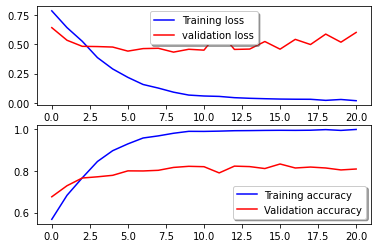

In [15]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Evaluation**: From the graphs, we see that while the training accuracy continues to improve until stagnating around the 8th epoch, the validation accuracy stagnates much faster at and around the 5th epoch.

The same is true of the validation loss, which stagnates around *0.4* while the training loss approaches *0*.

#### 4.1.5 Saving CNN model

In [16]:
cnn_model.save('basic-cnn.hdf5')

#### 4.1.6 Loading CNN model

In [17]:
cnn_model = tf.keras.models.load_model('basic-cnn.hdf5')

#### 4.1.7 Testing on Training Set
Testing on the training set, evaluating the accuracy and plotting the confusion matrix.

Accuracy = 0.9994444444444445


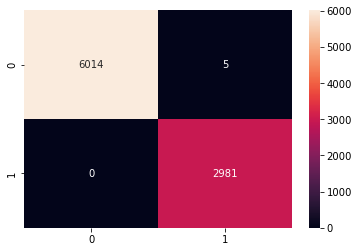

In [18]:
X_train = pickle.load(open('dataset/X_train','rb'))
Y_train = pickle.load(open('dataset/Y_train','rb'))

Y_true = np.argmax(Y_train,axis = 1)
Y_predicted = cnn_model.predict(X_train)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_true,Y_predicted)

#### 4.1.8 Testing on Validation Set
Testing on the validation set, then making a prediction of the training set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.8324444444444444


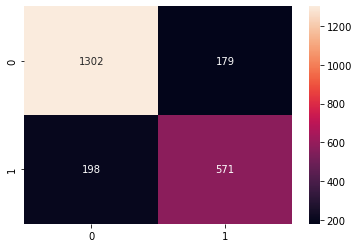

In [19]:
X_val = pickle.load(open('dataset/X_val','rb'))
Y_val = pickle.load(open('dataset/Y_val','rb'))

Y_true = np.argmax(Y_val,axis = 1)
Y_predicted = cnn_model.predict(X_val)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_true,Y_predicted)

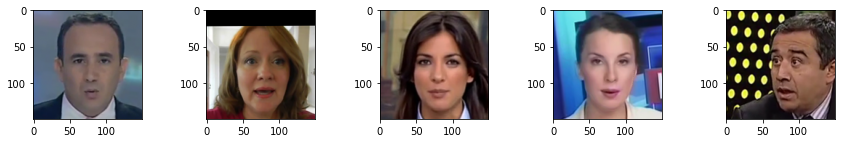

In [20]:
misconfig_X = X_val[Y_true!=Y_predicted]
misconfig_Y = Y_val[Y_true!=Y_predicted]
plot_image_grid(misconfig_X[0:100:20])

In [21]:
count = 0
for i in misconfig_Y[0:100:20]:
    count+= 1
    print('Image {} has been misclassified as {}'.format(count, 'Real' if np.argmax(i)==True else 'Fake'))

Image 1 has been misclassified as Real
Image 2 has been misclassified as Real
Image 3 has been misclassified as Real
Image 4 has been misclassified as Fake
Image 5 has been misclassified as Real


**Evaluation**: We can observe from the misclassified photographs that the basic CNN has difficulty correctly detecting Face2Face images. Other factors could include a background that isn't consistent or flat (3,4,5).

#### 4.1.9 Testing on Test Set
Testing on the testing set, then making a prediction of the training set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.7706666666666667


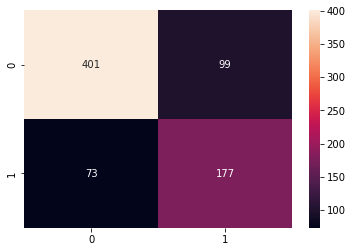

In [22]:
X_testing = pickle.load(open('dataset/X_testing','rb'))
Y_testing = pickle.load(open('dataset/Y_testing','rb'))

Y_predicted = cnn_model.predict(X_testing)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_testing,Y_predicted)

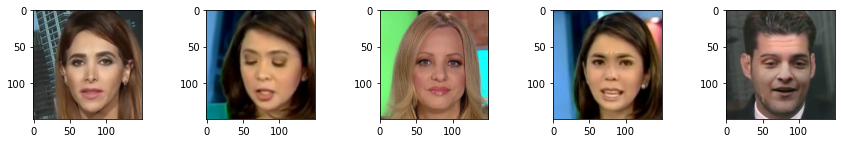

In [23]:
misconfig_X = X_testing[Y_testing!=Y_predicted]
misconfig_Y = Y_testing[Y_testing!=Y_predicted]
plot_image_grid(misconfig_X[0:150:30])

In [24]:
count = 0
for i in misconfig_Y[0:150:30]:
    count+= 1
    print('Image {} has been misclassified as {}'.format(count, 'Real' if i==True else 'Fake'))

Image 1 has been misclassified as Real
Image 2 has been misclassified as Real
Image 3 has been misclassified as Real
Image 4 has been misclassified as Fake
Image 5 has been misclassified as Fake


**Evaluation**: We notice a sharp decline in accuracy when the model predicts the labels on the validation and testing set compared to the testing set.



### 4.2 ResNet50

In [ ]:
X_train = pickle.load(open('dataset/X_train','rb'))
Y_train = pickle.load(open('dataset/Y_train','rb'))
X_val = pickle.load(open('dataset/X_val','rb'))
Y_val = pickle.load(open('dataset/Y_val','rb'))

#### 4.2.1 Architecture

**ResNet50**[3]: ResNet50 is a variation of the ResNet model. It has 48 convolutional layers, 1 MaxPool, and 1 average pooling layer. It has 3.8 x 10^9 floating-point arithmetic. It is a widely used ResNet model, and we explored the ResNet50 architecture in depth. 

We can see in table 1 the resnet 50 architecture contains the following components:

* A convolution with a kernel size of (7 * 7) and 64 different kernels with a stride of size 2 gives us **1 layer**. 

* Next, the max-pooling with also a stride size of 2. 

* In the next convolution, there is a (1 * 1), 64 kernel following this a (3 * 3), 64 kernel and at last a (1 * 1), 256 kernel. These three layers are repeated 3 times, giving us **9 layers** in this step.

* Next, the kernel of (1 * 1), 128 after a kernel of (3 * 3), 128, and at last a kernel of (1 * 1), 512. This step was repeated 4 times, giving us **12 layers** in this step.

* After that there is a kernal of (1 * 1), 256 and two more kernels with (3 * 3), 256 and (1 * 1), 1024. This is repeated 6 times, giving us a total of **18 layers**.

* And then, a (1 * 1), 512 kernel with two more of (3 * 3), 512 and (1 * 1), 2048 and this was repeated 3 times, giving us a total of **9 layers**.

* After that, do an average pool and end it with a fully connected layer containing 1000 nodes and a softmax function, giving **1 layer**.

* We don't actually count the activation functions and the max/ average pooling layers, totaling this it gives a **1 + 9 + 12 + 18 + 9 + 1 = 50 layers** Deep Convolutional network.ompared to the testing set.



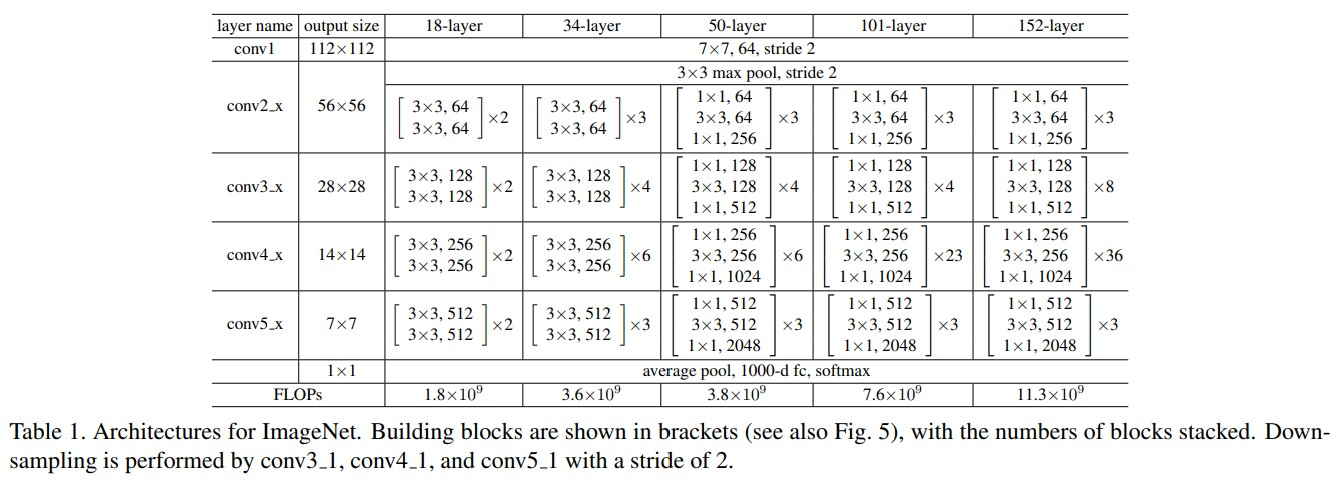

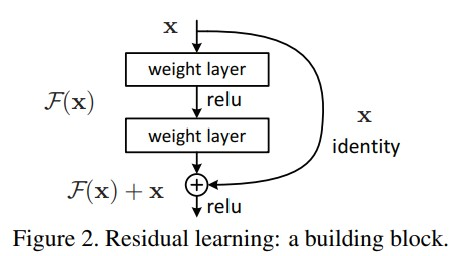

In [ ]:
%matplotlib inline

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

def custom_res():
    res_layer = ResNet50(weights='imagenet', include_top=False, classes=2, input_shape=(downscaling[0],downscaling[1],downscaling[2]))
    
    model = Sequential()
    model.add(res_layer)
    
    model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
    model.add(BatchNormalization()) 

    model.add(MaxPooling2D())
    model.add(Flatten())

    model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(2, activation = 'sigmoid'))
    
    return model

#### 4.2.2 Hyperparameter Optimisation

In [ ]:
def model_builder(hp):
    res_model = custom_res()
    
    res_model.summary()
    
    hp_learning = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
    
    res_model.compile(
        optimizer=Adam(learning_rate=hp_learning),
        loss = keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = ['accuracy']
    )

    return res_model

In [ ]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_accuracy',
    max_trials = 25,
    directory = 'mydir',
    project_name = 'keras-tuner-resnet'
)
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 0, mode = 'auto', restore_best_weights=True)

INFO:tensorflow:Reloading Oracle from existing project mydir\keras-tuner-resnet\oracle.json
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 64)          1179712   
                                                                 
 batch_normalization_4 (Batc  (None, 5, 5, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 batch_normalization_5 (Batc  (None, 5, 5, 64)         256       
 hNormalization)                                                 
                            

In [ ]:
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val, Y_val), callbacks=[early_stopping])

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

print(best_hps)


The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is 0.0001.



#### 4.2.3 Model training

Learning rate was fixed at `1e-4`. Then we iterated through the `batch_size` parameter in [16, 32, 64, 128, 256].
In the following cell, we have shown the training steps which resulted in the highest `val_accuracy` with `batch_size=128`

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 0, mode = 'auto', restore_best_weights=True)
#cnn_model = tuner.hypermodel.build(best_hps)
cnn_model = custom_res()
cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = ['accuracy'])
hist = cnn_model.fit(X_train, Y_train, epochs=29, batch_size=128, validation_data = (X_val, Y_val), callbacks=[early_stopping])

Epoch 1/29
282/282 [==============================] - 45s 139ms/step - loss: 0.4157 - accuracy: 0.8132 - val_loss: 0.6918 - val_accuracy: 0.5596
Epoch 2/29
282/282 [==============================] - 37s 133ms/step - loss: 0.1383 - accuracy: 0.9480 - val_loss: 0.6866 - val_accuracy: 0.5698
Epoch 3/29
282/282 [==============================] - 38s 133ms/step - loss: 0.0727 - accuracy: 0.9753 - val_loss: 0.5788 - val_accuracy: 0.7809
Epoch 4/29
282/282 [==============================] - 37s 132ms/step - loss: 0.0673 - accuracy: 0.9741 - val_loss: 0.1928 - val_accuracy: 0.9293
Epoch 5/29
282/282 [==============================] - 37s 132ms/step - loss: 0.0466 - accuracy: 0.9832 - val_loss: 0.1468 - val_accuracy: 0.9444
Epoch 6/29
282/282 [==============================] - 37s 132ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 0.1023 - val_accuracy: 0.9596
Epoch 7/29
282/282 [==============================] - 38s 133ms/step - loss: 0.0284 - accuracy: 0.9904 - val_loss: 0.3276 - val_ac

#### 4.2.4 Plots

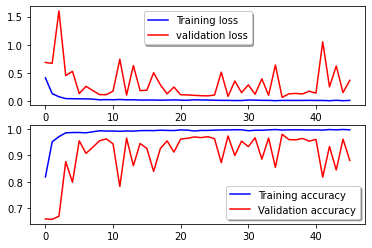

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Evaluation**: We see that training loss quickly approaches *0* when iterating through the epochs, but the validation loss is pretty unstable with frequent crests and troughs. It is essential to use the callback to retrieve the weights that minimise the validation loss values.

A similar trend is seen with the training and test accuracies. The spikes in validation loss sync up with falls in validation accuracy.

Ref: http://proceedings.mlr.press/v130/hayou21a/hayou21a.pdf

#### 4.2.5 Saving ResNet CNN model

In [27]:
cnn_model.save('resnet50-cnn.hdf5')

C:\ProgramData\Anaconda3\envs\tensorflow-keras\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


#### 4.2.6 Loading ResNet50 CNN model

In [31]:
cnn_model = keras.models.load_model('resnet50-cnn.hdf5')

#### 4.2.7 Visualising the ResNet50 Model Architechture

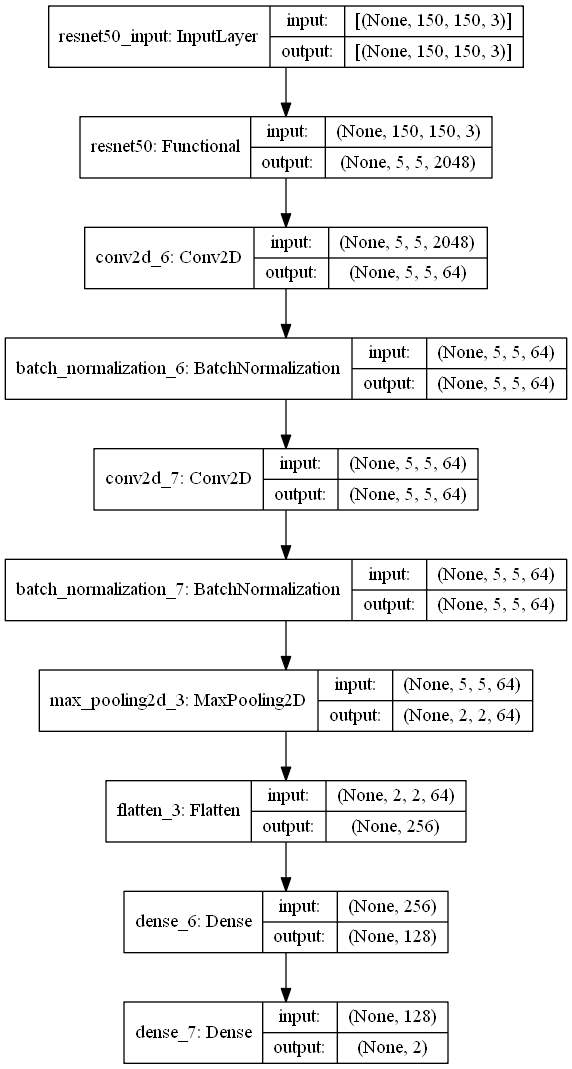

In [32]:
keras.utils.vis_utils.plot_model(cnn_model, to_file='resnet50-cnn.png', show_shapes=True)

#### 4.2.8 Testing on Training Set
Testing on the training set, then making a prediction of the training set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.9994444444444445


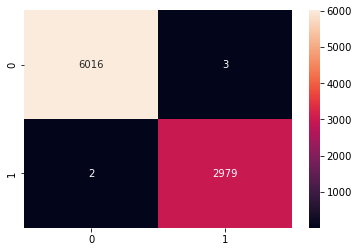

In [33]:
X_train = pickle.load(open('dataset/X_train','rb'))
Y_train = pickle.load(open('dataset/Y_train','rb'))

Y_true = np.argmax(Y_train,axis = 1)
Y_predicted = cnn_model.predict(X_train)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_true,Y_predicted)

#### 4.2.9 Testing on Validation Set
Testing on the validation set, then making a prediction of the validation set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.9804444444444445


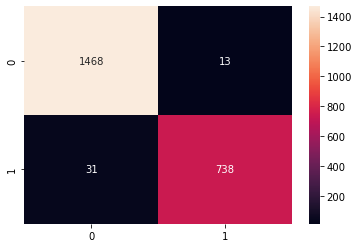

In [34]:
X_val = pickle.load(open('dataset/X_val','rb'))
Y_val = pickle.load(open('dataset/Y_val','rb'))

Y_true = np.argmax(Y_val,axis = 1)
Y_predicted = cnn_model.predict(X_val)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_true,Y_predicted)

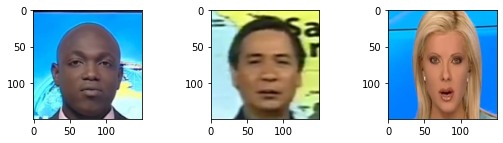

In [35]:
misconfig_X = X_val[Y_true!=Y_predicted]
misconfig_Y = Y_val[Y_true!=Y_predicted]
plot_image_grid(misconfig_X[0:100:15])

In [36]:
count = 0
for i in misconfig_Y[0:100:15]:
    count+= 1
    print('Image {} has been misclassified as {}'.format(count, 'Real' if np.argmax(i)==True else 'Fake'))

Image 1 has been misclassified as Real
Image 2 has been misclassified as Real
Image 3 has been misclassified as Fake


**Evaluation**: Compared to the Basic CNN, The ResNet50 performed much better on the validation set (val_acc of 0.98 vs 0.83). The instances of misclassification might be due to inconsistent backgrounds (1), blur (2) or specific face2face images (3).

#### 4.2.10 Testing on Testing Set
Testing on the testing set, then making a prediction of the testing set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.9346666666666666


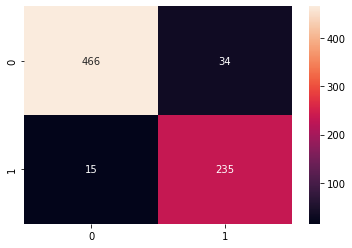

In [ ]:
X_testing = pickle.load(open('dataset/X_testing','rb'))
Y_testing = pickle.load(open('dataset/Y_testing','rb'))

Y_predicted = cnn_model.predict(X_testing)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_testing,Y_predicted)

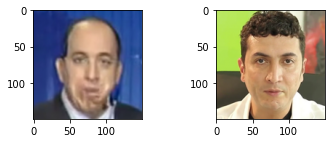

In [ ]:
misconfig_X = X_testing[Y_testing!=Y_predicted]
misconfig_Y = Y_testing[Y_testing!=Y_predicted]
plot_image_grid(misconfig_X[0:150:30])

In [ ]:
count = 0
for i in misconfig_Y[0:150:30]:
    count+= 1
    print('Image {} has been misclassified as {}'.format(count, 'Real' if i==True else 'Fake'))

Image 1 has been misclassified as Real
Image 2 has been misclassified as Fake


**Evaluation**: The performance on the testing set by the RestNet50 model was better than the Basic CNN by a large margin (test_acc of 0.934 vs 0.77).

### 4.3 EfficientNet B3

In [8]:
X_train = pickle.load(open('dataset/X_train','rb'))
Y_train = pickle.load(open('dataset/Y_train','rb'))
X_val = pickle.load(open('dataset/X_val','rb'))
Y_val = pickle.load(open('dataset/Y_val','rb'))

#### 4.3.1 Architecture

**EfficientNet**: is a convolutional neural network architecture and scaling method, which uses composite coefficients to uniformly scale all dimensions of depth/width/resolution. Unlike the traditional process of scaling these factors arbitrarily, the EfficientNet scaling method uses a set of fixed scaling factors to uniformly scale the network's width, depth, and resolution. For example, suppose we want to use 2^N times the computing resources. In that case, we can simply increase the depth of the network by alpha^N. Increase the width by beta^N, and increase the image size by gamma^N, where (alpha, beta, gamma) is the constant coefficients determined by the small grid search of the original miniature model. EfficientNet uses the composite coefficient phi to uniformly scale the network width, depth, and resolution in a principled manner.

The reason for adopting the composite scaling method is that if the input image is larger. The network needs more layers to increase the receptive field and more channels to capture more fine-grained patterns on the larger image.

The below is the architecture of the **EfficientNet B3**. The **Stem layer** is the input layer, which has different elements shown in the image below. 

The overarching architecture

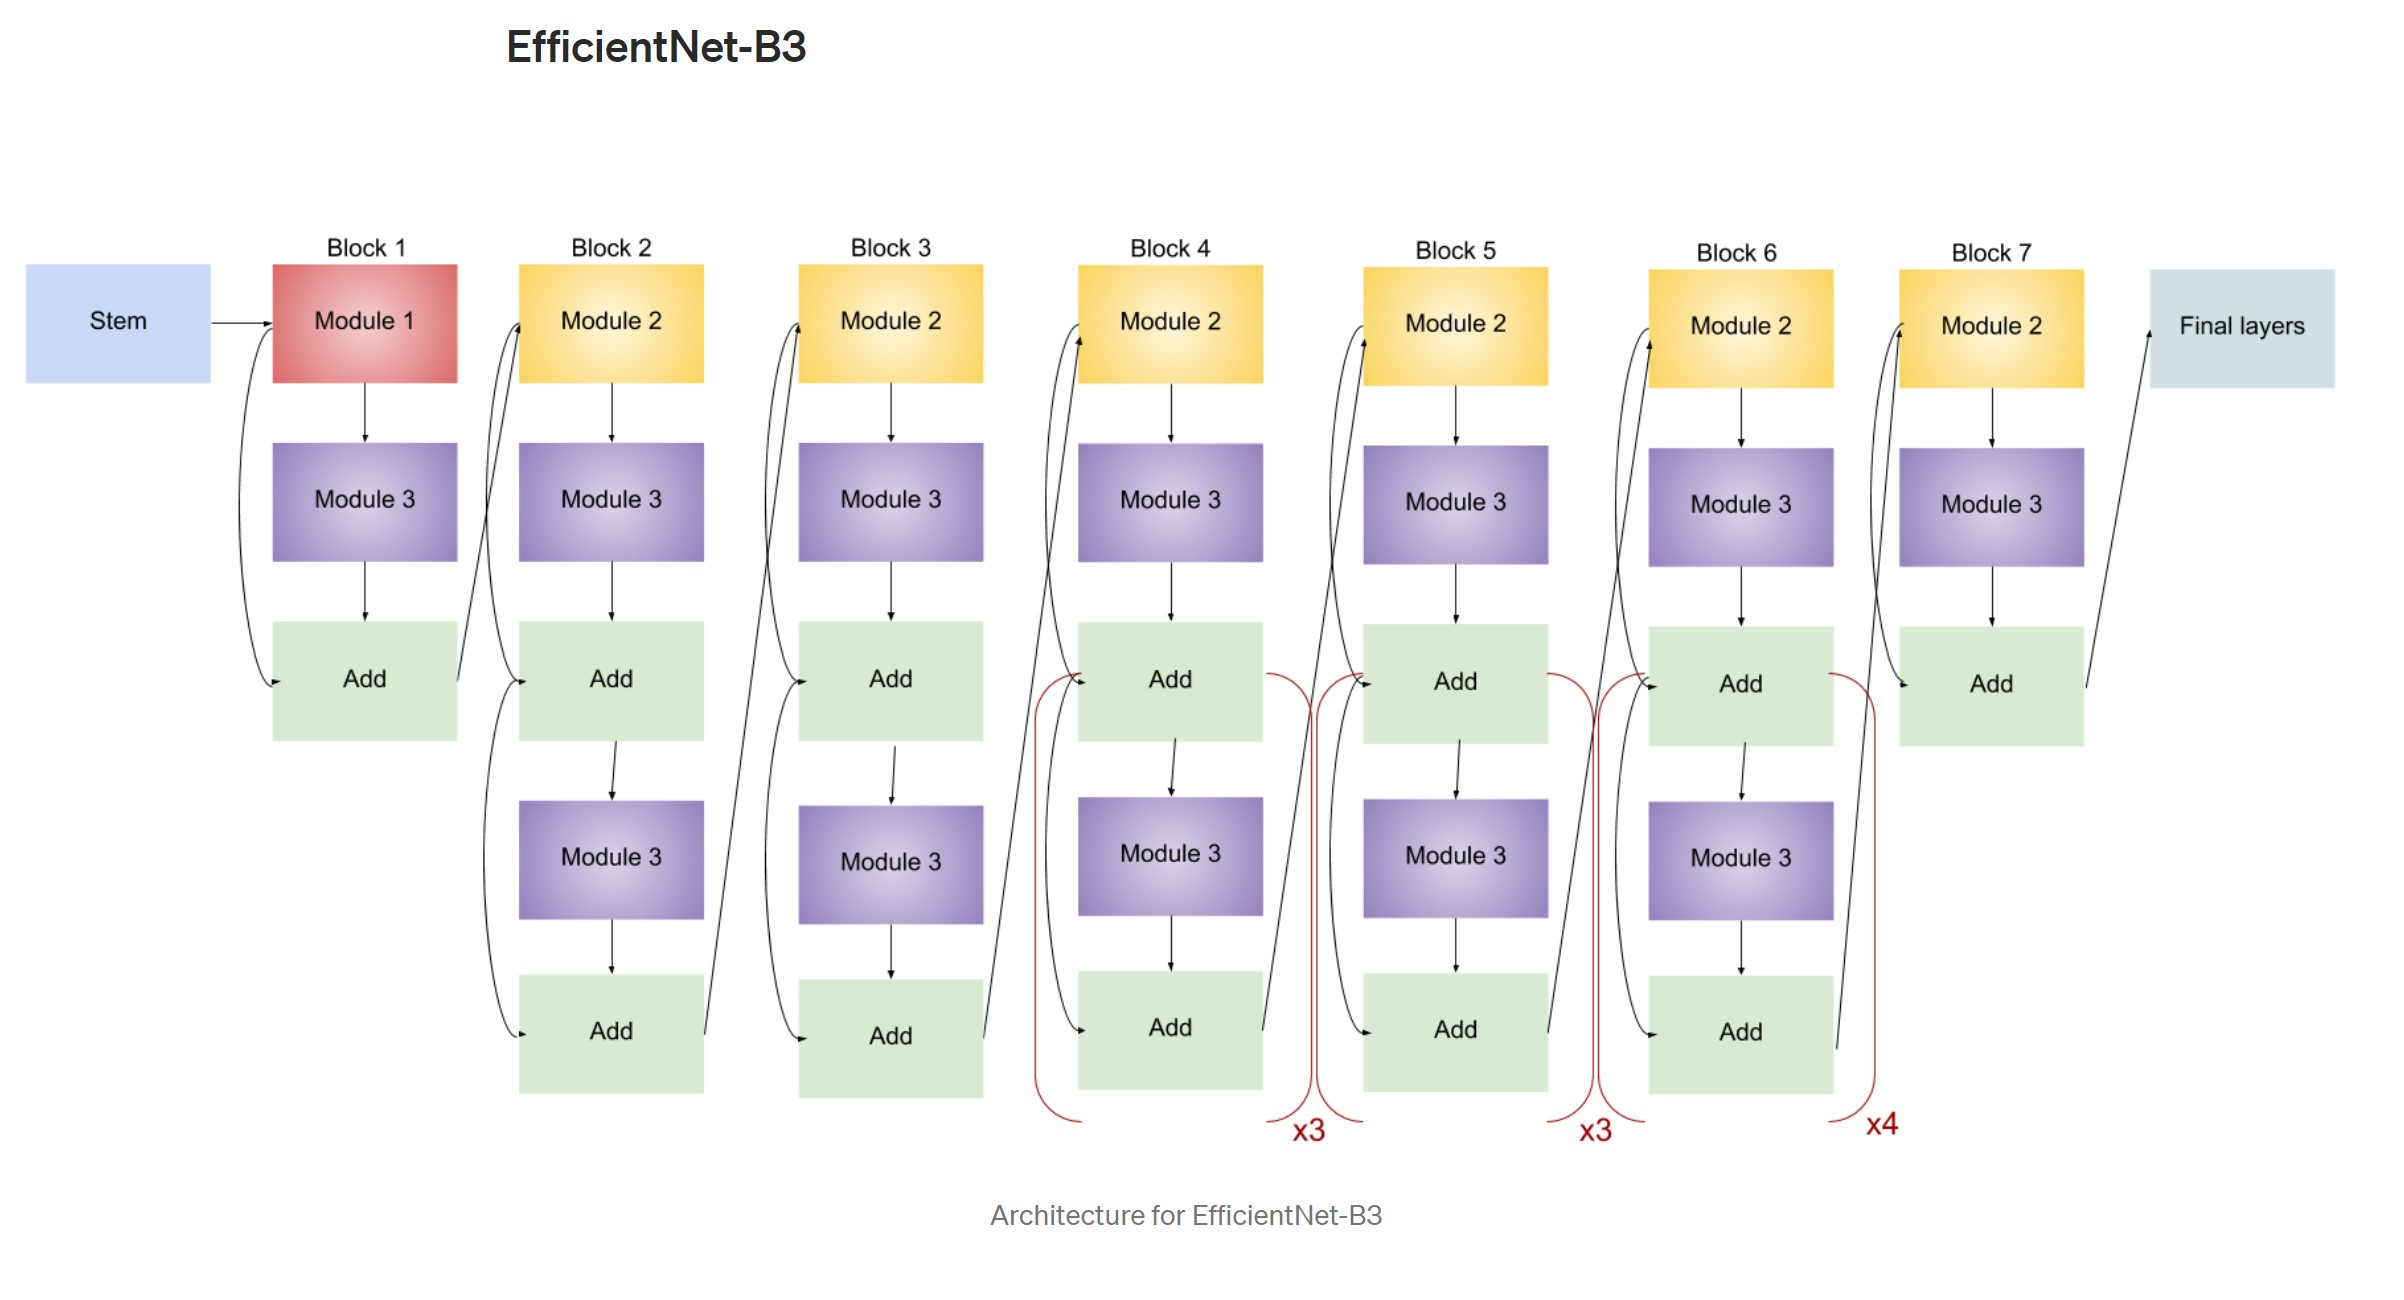

The Intial Stem Layer and Final Layers have been displayed below

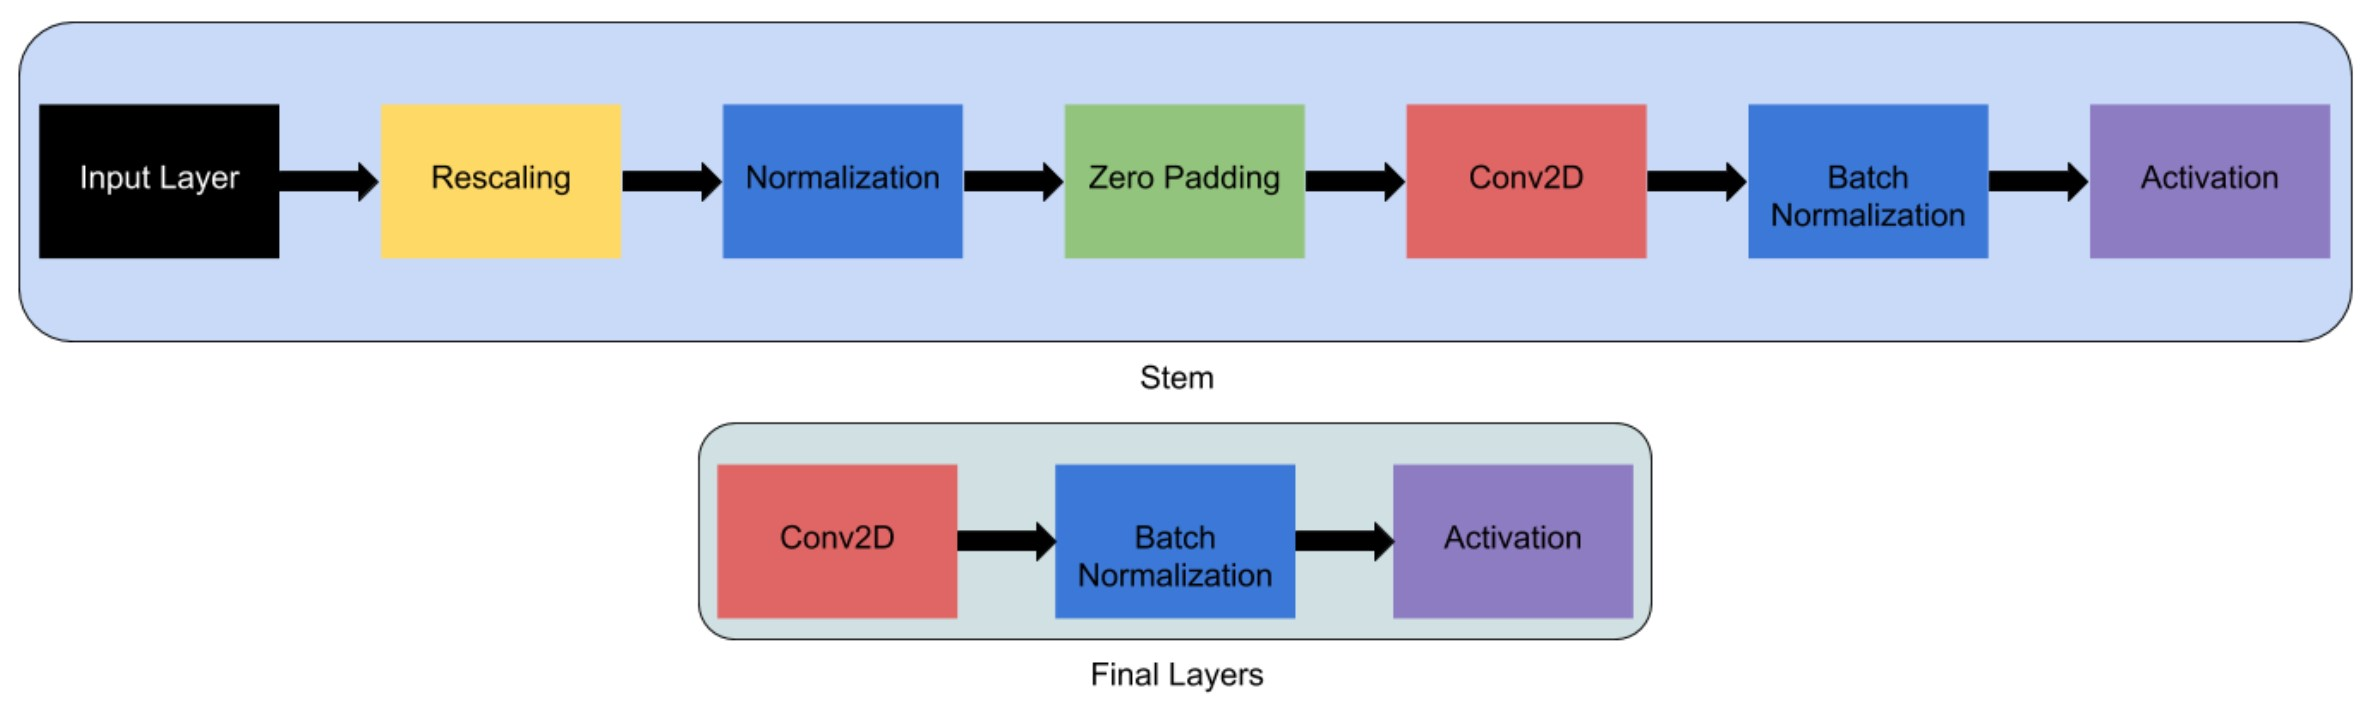

The individual modules of the first image has been portrayed in detail below

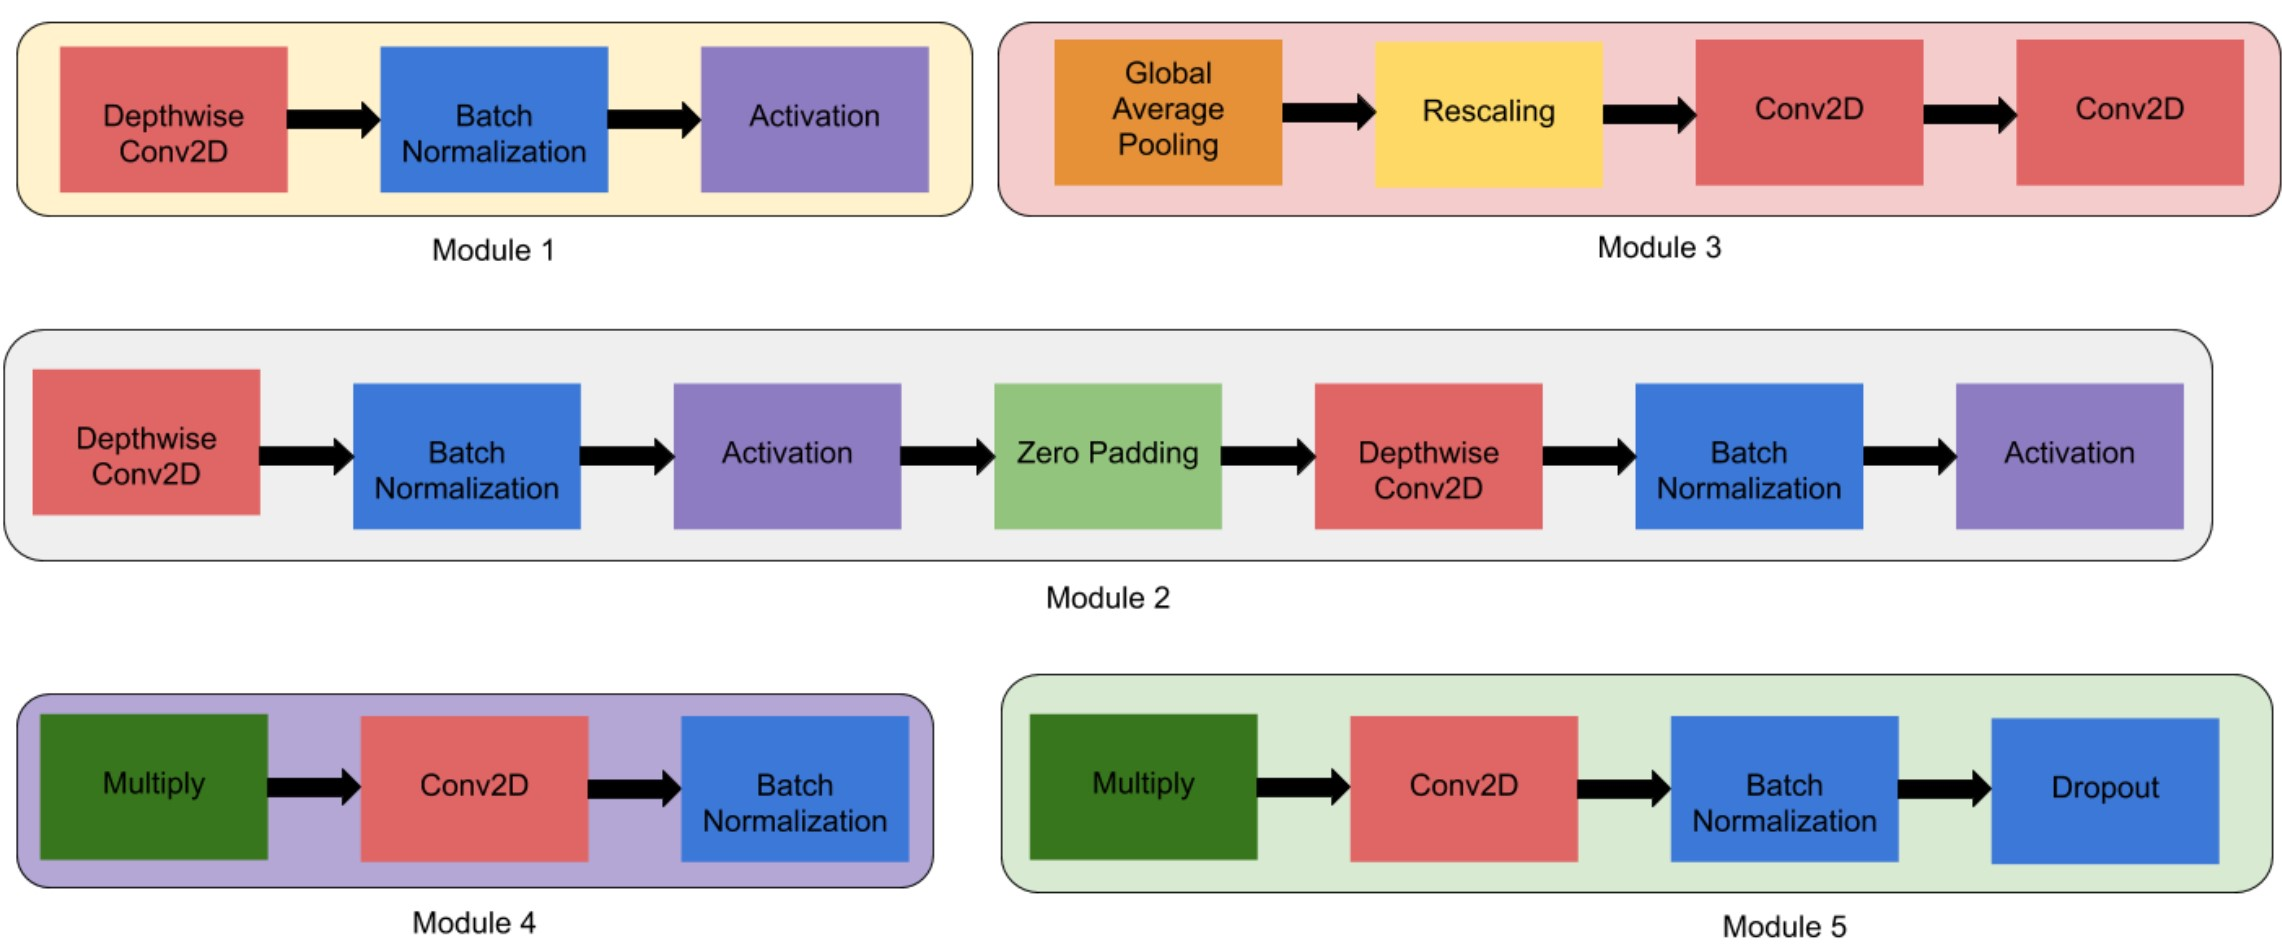

In [9]:
%matplotlib inline
from tensorflow.keras.applications import EfficientNetB3

def custom_efn():
    efn_layer = EfficientNetB3(weights='imagenet', include_top=False, classes=2, input_shape=(downscaling[0],downscaling[1],downscaling[2]))
    
    model = Sequential()
    model.add(efn_layer)
    
    model.add(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
    model.add(BatchNormalization()) 

    model.add(MaxPooling2D())
    model.add(Flatten())

    model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(2, activation = 'sigmoid'))

    return model

#### 4.3.2 Hyperparameter Optimisation

In [10]:
def model_builder(hp):
    efn_model = custom_efn()
    
    efn_model.summary()
    
    hp_learning = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
    
    efn_model.compile(
        optimizer=Adam(learning_rate=hp_learning),
        loss = keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = ['accuracy']
    )

    return efn_model

In [11]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_accuracy',
    max_trials = 10,
    directory = 'mydir',
    project_name = 'keras-tuner-efficientNetB3'
)
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 7, verbose = 0, mode = 'auto', restore_best_weights=True)

INFO:tensorflow:Reloading Oracle from existing project mydir\keras-tuner-efficientNetB3\oracle.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 5, 5, 1536)       10783535  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          884800    
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 5, 64)         256       
 hNormalization)                                                 
                      

In [12]:
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val, Y_val), callbacks=[early_stopping])

INFO:tensorflow:Oracle triggered exit


In [13]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

print(best_hps)


The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is 0.001.



#### 4.3.3 Model training

The hyperparameter tuning initially set the optimal learning rate to `1e-3`. But in our tests, the model failed to converge or show any meaningful increase in validation accuracy even after training for 50 epochs and iterating through the `batch_sizes` of [16, 32, 64, 128, 256].

Thus, we lowered the learning rate to `1e-4` but faced unexpected spikes in validation loss.

Finally, at `1e-5`and `batch_size=64`, we were able to obtain good validation accuracies.

In [14]:
#cnn_model = tuner.hypermodel.build(best_hps)
cnn_model = custom_efn()
cnn_model.compile(optimizer=Adam(learning_rate=1e-3), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = ['accuracy'])
hist = cnn_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data = (X_val, Y_val), callbacks=[early_stopping])

Epoch 1/50
141/141 [==============================] - 78s 446ms/step - loss: 0.5130 - accuracy: 0.7592 - val_loss: 0.6555 - val_accuracy: 0.6582
Epoch 2/50
141/141 [==============================] - 59s 421ms/step - loss: 0.2632 - accuracy: 0.8893 - val_loss: 0.6491 - val_accuracy: 0.6582
Epoch 3/50
141/141 [==============================] - 60s 427ms/step - loss: 0.1356 - accuracy: 0.9506 - val_loss: 0.6961 - val_accuracy: 0.6582
Epoch 4/50
141/141 [==============================] - 60s 426ms/step - loss: 0.0919 - accuracy: 0.9658 - val_loss: 0.6705 - val_accuracy: 0.6582
Epoch 5/50
141/141 [==============================] - 60s 427ms/step - loss: 0.0715 - accuracy: 0.9739 - val_loss: 0.7292 - val_accuracy: 0.6582
Epoch 6/50
141/141 [==============================] - 61s 430ms/step - loss: 0.0561 - accuracy: 0.9791 - val_loss: 0.7311 - val_accuracy: 0.6596
Epoch 7/50
141/141 [==============================] - 61s 429ms/step - loss: 0.0451 - accuracy: 0.9832 - val_loss: 1.2959 - val_ac

#### 4.3.4 Plots

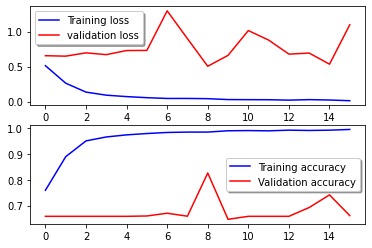

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Evaluation**: The custom EfficientNetB3 model has shown worse stablility and validation accuracies when compared to the ResNet50 model. The validation accuracy reached a high of around 0.82 at the 9th epoch.

It also takes much longer per epoch for the EfficientNetB3 model to be trained as compared to the ResNet50 model (60 secs vs 37 secs).

#### 4.3.5 Saving EfficientNet B3 CNN model

In [16]:
cnn_model.save('efnb3-cnn.hdf5')

C:\ProgramData\Anaconda3\envs\tensorflow-keras\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#### 4.3.6 Loading EfficientNet B3 CNN model

In [8]:
cnn_model = keras.models.load_model('efnb3-cnn.hdf5')

#### 4.3.7 Visualising the EfficientNet B3 Model Architechture Diagram

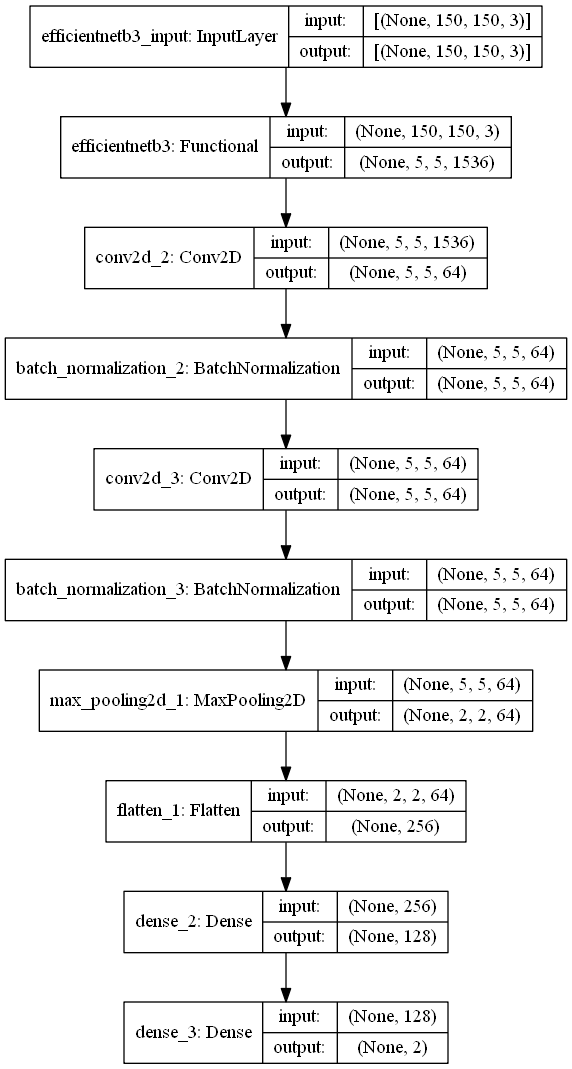

In [9]:
keras.utils.vis_utils.plot_model(cnn_model, to_file='efnb3-cnn.png', show_shapes=True)

#### 4.3.8 Testing on Training Set
Testing on the training set, then making a prediction of the training set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.3456666666666667


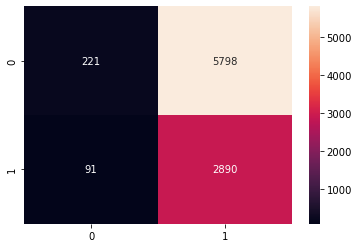

In [10]:
X_train = pickle.load(open('dataset/X_train','rb'))
Y_train = pickle.load(open('dataset/Y_train','rb'))

Y_true = np.argmax(Y_train,axis = 1)
Y_predicted = np.array(cnn_model.predict(X_train), dtype=np.int64)
Y_predicted2 = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_true,Y_predicted2)

#### 4.3.9 Testing on Validation Set
Testing on the validation set, then making a prediction of the validation set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.35244444444444445


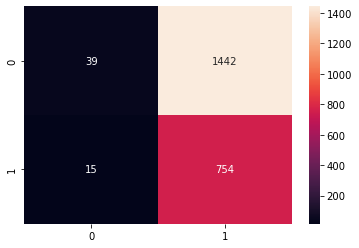

In [27]:
X_val = pickle.load(open('dataset/X_val','rb'))
Y_val = pickle.load(open('dataset/Y_val','rb'))

Y_true = np.argmax(Y_val,axis = 1)
Y_predicted = cnn_model.predict(X_val)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_true,Y_predicted)

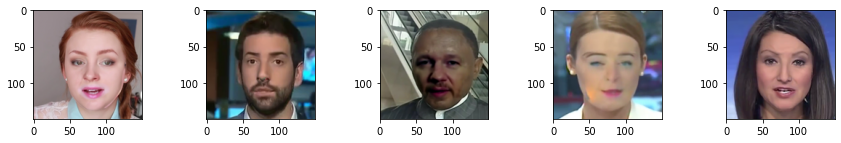

In [28]:
misconfig_X = X_val[Y_true!=Y_predicted]
misconfig_Y = Y_val[Y_true!=Y_predicted]
plot_image_grid(misconfig_X[0:100:20])

In [25]:
count = 0
for i in misconfig_Y[0:100:20]:
    count+= 1
    print('Image {} has been classified as {}'.format(count, 'Real' if np.argmax(i)==True else 'Fake'))

Image 1 has been classified as Fake
Image 2 has been classified as Fake
Image 3 has been classified as Fake
Image 4 has been classified as Fake
Image 5 has been classified as Fake


**Evaluation**: Compared to the training and validation accuracies we observed during the training phase, the actual peformance of the model is poor. This may due to it not sufficiently understanding the features of the image set within the limited set of epochs was able to iterate through

#### 4.3.10 Testing on Testing Set
Testing on the testing set, then making a prediction of the testing set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.3546666666666667


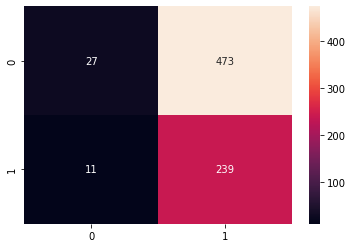

In [18]:
X_testing = pickle.load(open('dataset/X_testing','rb'))
Y_testing = pickle.load(open('dataset/Y_testing','rb'))

Y_predicted = cnn_model.predict(X_testing)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_testing,Y_predicted)

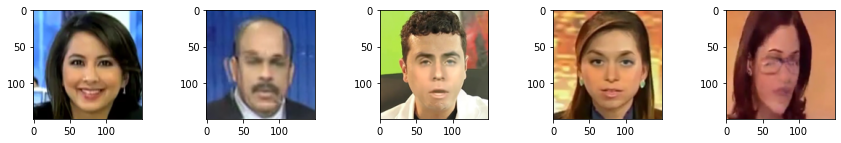

In [21]:
misconfig_X = X_testing[Y_testing!=Y_predicted]
misconfig_Y = Y_testing[Y_testing!=Y_predicted]
plot_image_grid(misconfig_X[0:100:20])

In [26]:
count = 0
for i in misconfig_Y[0:100:20]:
    count+= 1
    print('Image {} has been classified as {}'.format(count, 'Real' if i==True else 'Fake'))

Image 1 has been classified as Real
Image 2 has been classified as Fake
Image 3 has been classified as Fake
Image 4 has been classified as Fake
Image 5 has been classified as Fake


### 4.4 MobileNet V2

In [ ]:
X_train = pickle.load(open('dataset/X_train','rb'))
Y_train = pickle.load(open('dataset/Y_train','rb'))
X_val = pickle.load(open('dataset/X_val','rb'))
Y_val = pickle.load(open('dataset/Y_val','rb'))

#### 4.4.1 Architecture



**MobileNetV2** is a convolutional neural network architecture, which strives to perform well on mobile devices. It is based on the reverse residual structure, in which the residual connection is located between the bottleneck layers. The middle expansion layer uses lightweight deep convolution to filter features that are sources of non-linearity. In summary, the architecture of MobileNetV2 includes an initial fully convolutional layer with 32 filters, followed by 19 residual bottleneck layers.

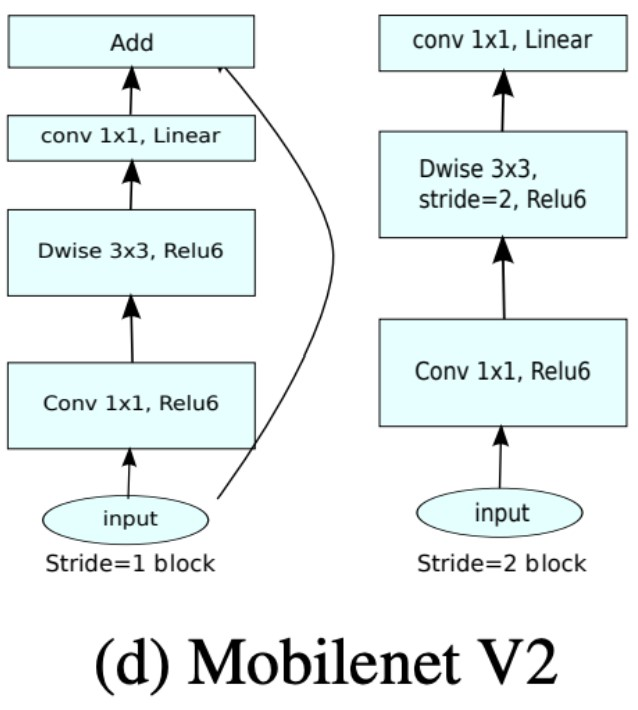

In [ ]:
%matplotlib inline
from tensorflow.keras.applications import MobileNetV2

def custom_mobile():
    deep_layer = MobileNetV2(weights='imagenet', include_top=False, alpha=1.4, classes=2, input_shape=(downscaling[0],downscaling[1], downscaling[2]))
    
    model = Sequential()
    model.add(deep_layer)
    
    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
    model.add(BatchNormalization()) 

    model.add(MaxPooling2D())
    model.add(Flatten())

    model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(2, activation = 'sigmoid'))

    return model

#### 4.4.2 Hyperparameter Optimisation

In [ ]:
def model_builder(hp):
    efn_model = custom_mobile()
    
    efn_model.summary()
    
    hp_learning = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
    
    efn_model.compile(
        optimizer=Adam(learning_rate=hp_learning),
        loss = keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = ['accuracy']
    )

    return efn_model

In [ ]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_accuracy',
    max_trials = 10,
    directory = 'mydir',
    project_name = 'keras-tuner-mobileNetV2'
)
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, verbose = 0, mode = 'auto', restore_best_weights=True)

INFO:tensorflow:Reloading Oracle from existing project mydir\keras-tuner-mobileNetV2\oracle.json
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.40_224 (Funct  (None, 5, 5, 1792)       4363712   
 ional)                                                          
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 64)          1032256   
                                                                 
 batch_normalization_10 (Bat  (None, 5, 5, 64)         256       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 5, 5, 64)          36928     
                                                                 
 batch_normalization_11 (Bat  (None, 5, 5, 64)         256       
 chNormalization)      

In [ ]:
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val, Y_val), callbacks=[early_stopping])

Trial 11 Complete [00h 15m 39s]
val_accuracy: 0.9733333587646484

Best val_accuracy So Far: 0.9737777709960938
Total elapsed time: 02h 32m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

print(best_hps)


The hyperparameter search is complete. 
The optimal learning rate for the optimizer
is 0.0001.



#### 4.4.3 Model training

In [ ]:
#cnn_model = tuner.hypermodel.build(best_hps)
cnn_model = custom_mobile()
cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = ['accuracy'])
hist = cnn_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data = (X_val, Y_val), callbacks=[early_stopping])

Epoch 1/50
282/282 [==============================] - 40s 129ms/step - loss: 0.5360 - accuracy: 0.7463 - val_loss: 1.8233 - val_accuracy: 0.6591
Epoch 2/50
282/282 [==============================] - 35s 126ms/step - loss: 0.2161 - accuracy: 0.9138 - val_loss: 1.8163 - val_accuracy: 0.6587
Epoch 3/50
282/282 [==============================] - 35s 125ms/step - loss: 0.1078 - accuracy: 0.9583 - val_loss: 3.5185 - val_accuracy: 0.6591
Epoch 4/50
282/282 [==============================] - 35s 124ms/step - loss: 0.0708 - accuracy: 0.9738 - val_loss: 2.8870 - val_accuracy: 0.6658
Epoch 5/50
282/282 [==============================] - 36s 127ms/step - loss: 0.0524 - accuracy: 0.9809 - val_loss: 3.0158 - val_accuracy: 0.6636
Epoch 6/50
282/282 [==============================] - 36s 126ms/step - loss: 0.0454 - accuracy: 0.9849 - val_loss: 1.8848 - val_accuracy: 0.7124
Epoch 7/50
282/282 [==============================] - 36s 127ms/step - loss: 0.0406 - accuracy: 0.9854 - val_loss: 1.1263 - val_ac

#### 4.4.4 Plots

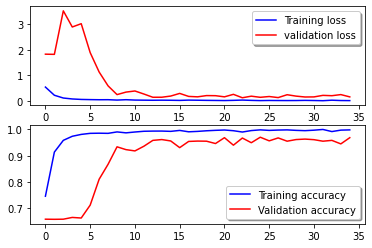

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Evaluation**: The MobileNetV2 model performed quite similarly to the ResNet50 in terms of max accuracies and min losses but the model is much more stable as the curves don't show huge spikes or troughs in between epochs. It also converges on the training set and validation set faster than the custom EfficientNetB3.

#### 4.4.5 Saving MobileNet V2 CNN model

In [ ]:
cnn_model.save('mobilev2-cnn.hdf5')

C:\ProgramData\Anaconda3\envs\tensorflow-keras\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#### 4.4.6 Loading MobileNet V2 CNN model

In [50]:
cnn_model = keras.models.load_model('mobilev2-cnn.hdf5')

#### 4.4.7 Visualising the MobileNet V2 Model Architechture Diagram

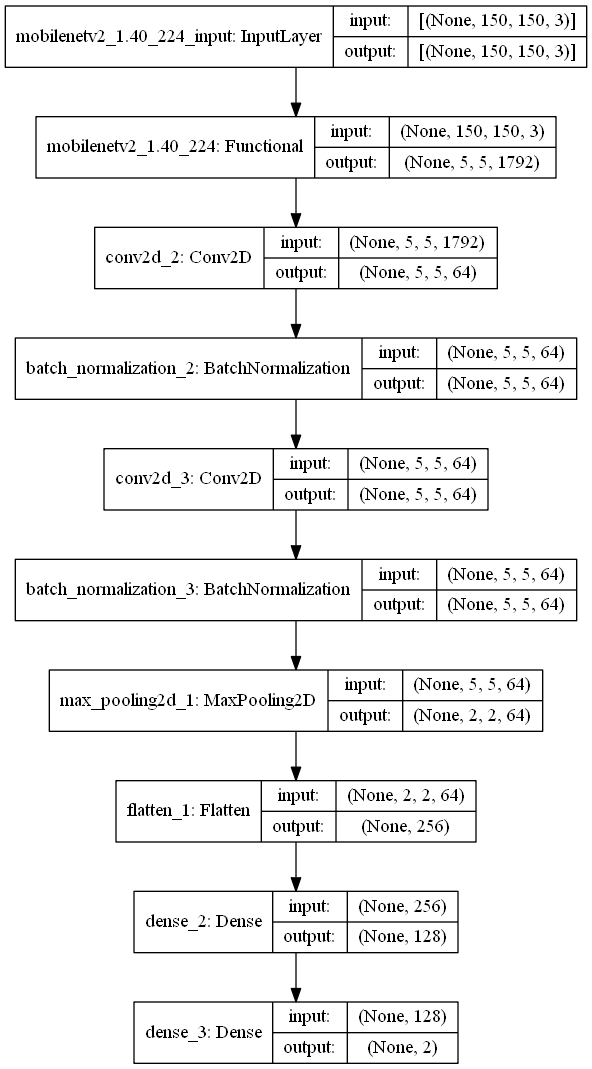

In [51]:
keras.utils.vis_utils.plot_model(cnn_model, to_file='mobilev2-cnn.png', show_shapes=True)

#### 4.4.8 Testing on Training Set
Testing on the training set, then making a prediction of the training set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.999


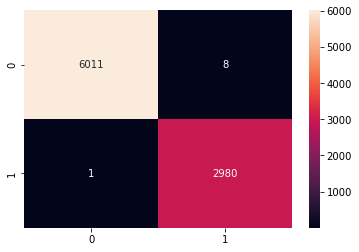

In [52]:
X_train = pickle.load(open('dataset/X_train','rb'))
Y_train = pickle.load(open('dataset/Y_train','rb'))

Y_true = np.argmax(Y_train,axis = 1)
Y_predicted = cnn_model.predict(X_train)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_true,Y_predicted)

#### 4.4.9 Testing on Validation Set
Testing on the validation set, then making a prediction of the validation set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.9702222222222222


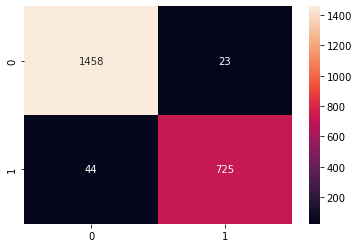

In [53]:
X_val = pickle.load(open('dataset/X_val','rb'))
Y_val = pickle.load(open('dataset/Y_val','rb'))

Y_true = np.argmax(Y_val,axis = 1)
Y_predicted = cnn_model.predict(X_val)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_true,Y_predicted)

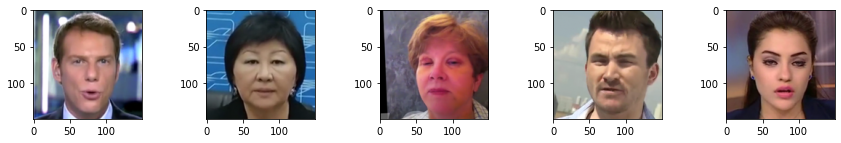

In [54]:
misconfig_X = X_val[Y_true!=Y_predicted]
misconfig_Y = Y_val[Y_true!=Y_predicted]
plot_image_grid(misconfig_X[0:100:15])

In [55]:
count = 0
for i in misconfig_Y[0:100:15]:
    count+= 1
    print('Image {} has been misclassified as {}'.format(count, 'Real' if np.argmax(i)==True else 'Fake'))

Image 1 has been misclassified as Real
Image 2 has been misclassified as Real
Image 3 has been misclassified as Fake
Image 4 has been misclassified as Fake
Image 5 has been misclassified as Real


**Evaluation**: Accuracies on the validation set where also similar to that of the ResNET50 model and within margin of eror. Congruent to what we have seen before 

#### 4.4.10 Testing on Testing Set
Testing on the testing set, then making a prediction of the testing set, evaluating the accuracy and ploting the confusion matrix.

Accuracy = 0.936


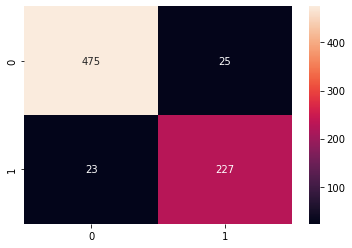

In [56]:
X_testing = pickle.load(open('dataset/X_testing','rb'))
Y_testing = pickle.load(open('dataset/Y_testing','rb'))

Y_predicted = cnn_model.predict(X_testing)
Y_predicted = np.argmax(Y_predicted,axis = 1)

plot_confusion_matrix(Y_testing,Y_predicted)

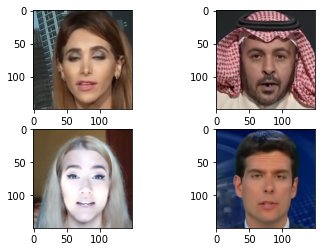

In [57]:
misconfig_X = X_testing[Y_testing!=Y_predicted]
misconfig_Y = Y_testing[Y_testing!=Y_predicted]
plot_image_grid(misconfig_X[0:75:15])

In [58]:
count = 0
for i in misconfig_Y[0:75:15]:
    count+= 1
    print('Image {} has been misclassified as {}'.format(count, 'Real' if i==True else 'Fake'))

Image 1 has been misclassified as Real
Image 2 has been misclassified as Real
Image 3 has been misclassified as Fake
Image 4 has been misclassified as Fake


**Evaluation**: The MobileNetV2 model performs very well on the testing set but fails to identify images that may be brightened (3)

## 5. Testing Function

---

In [20]:
# Run this cell to load the model and begin the testing process 
#
#
from glob import glob
import cv2
import pandas as pd

loading_model = 'mobilev2-cnn.hdf5'

try:
    cnn_model = keras.models.load_model(loading_model)
    print('Model loaded.')
except:
    print('Model not available.')

Model loaded.


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

def test(img_path_list, true_class_list):
    
    test_image_dataset = []
    
    # Storing all images in a list
    for image in img_path_list:
        temp_image = np.array(Image.open(full_path).convert('RGB'))
        test_image_dataset.append(temp_image)
    
    # Downscaling the image to ()
    test_image_dataset = convert_resize(test_image_dataset).reshape(-1, downscaling[0], downscaling[1], downscaling[2])
    #test_image_dataset = test_image_dataset.
    
    # 1 for Real & 0 for Fake
    predicted_values = cnn_model.predict(test_image_dataset)
    
    predicted_values = np.argmax(predicted_values,axis = 1)
    
    print("Final Results have been calculated")
    
    accuracy = accuracy_score(true_class_list,predValues)
    recall = recall_score(true_class_list,predValues, average=None)
    precision = precision_score(true_class_list,predValues, average=None)
    
    return accuracy, recall, precision

## 6. Summary

---
- In terms of pure accuracy values on the training, validation and testing set, the custom ResNet50 is definitely the best of the 3 models tested.
    1. Training = 0.99
    2. Validation = 0.98
    3. Testing = 0.93
    
    
- The custom MobileNetV2 model is a close second and can even be the preferred model if stability is an important facet.
    1. Training = 0.99
    2. Validation = 0.97
    3. Testing = 0.93   


## 7. References 

---
**Academic Papers:**  
[1] Afchar, D., Nozick, V., Yamagishi, J., & Echizen, I. (2018). *MesoNet: A Compact Facial Video Forgery Detection Network.*  

[2] Agarwal, V. (2020, May 31). *Complete architectural details of all EfficientNet models. Medium.* Retrieved December 9, 2021, from https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142. 

[3] C. G. Sri, S. Bano, T. Deepika, N. Kola and Y. L. Pranathi. (2021). *"Deep Neural Networks Based Error Level Analysis for Lossless Image Compression Based Forgery Detection," 2021 International Conference on Intelligent Technologies (CONIT)*, pp. 1-8, doi: 10.1109/CONIT51480.2021.9498357.  

[4] Explained | Papers With Code. (n.d.). *Papers with code - efficientnet explained. EfficientNet.* Retrieved December 9, 2021, from https://paperswithcode.com/method/efficientnet. 

[5] Explained | Papers With Code. (n.d.). *Papers with code - mobilenetv2 explained. MobileNetV2.* Retrieved December 9, 2021, from https://paperswithcode.com/method/mobilenetv2.

[6] He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Deep Residual Learning for Image Recognition.* 

[7] I. B. K. Sudiatmika and F. Rahman. (2019). *Image forgery detection using error level analysis and deeplearning*, Telkomnika, vol. 17, no. 2, pp. 653–659.

[8] Kawa, P., &amp; Syga, P. (2021). *Verify It Yourself: A Note on Activation Functions’ Influence on Fast DeepFake Detection.* In Proceedings of the 18th International Conference on Security and Cryptography (SECRYPT 2021), 18, pp. 779–784. https://doi.org/10.5220/0010581707790784  

[9] Li, Y., & Lyu, S. (2018). *Exposing DeepFake Videos By Detecting Face Warping Artifacts.*  

[10] Pashine, S., Mandiya, S., Gupta, P., & Sheikh, R. (2021). *Deep Fake Detection: Survey of Facial Manipulation Detection Solutions. * 

[11] Prash. (2021, May 23). *Using Gans in error level analysis for detecting possible image fakes. Medium.* Retrieved November 24, 2021, from    https://simpleprash.medium.comusing-gans-in-error-level-analysis-for-detecting-possible-image-fakes-d2fce7a7aa08

[12] Salpekar, O. (n.d.). *Deepfake image detection - stanford university.* Retrieved November 23, 2021, from http://cs230.stanford.edu/projects_spring_2020/reports/38857501.pdf.  

[13] Tan, M., & Le, Q. V. (2019). *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.*

**Github Repository:**  
[14] Kiteco. (2020, July 11). *Python-youtube-code/deepfake-detection at master · KITECO/Python-YouTube-code*. GitHub. Retrieved November 23, 2021, from https://github.com/kiteco/python-youtube-code/tree/master/Deepfake-detection.   

**Kaggle datasets:**  

[15] Deepfake Detection Challenge. Kaggle. (n.d.). Retrieved November 23, 2021, from https://www.kaggle.com/c/deepfake-detection-challenge/data.  

[16] DeepFake Starter Kit. (n.d.). Retrieved November 23, 2021, from https://www.kaggle.com/gpreda/deepfake-starter-kit/notebook.  

[17] Kaggle DeepFake Detection Introduction. (n.d.). Retrieved November 23, 2021, from https://www.kaggle.com/robikscube/kaggle-deepfake-detection-introduction.  
